# UMAP Decoder
If a dataset can be well separated by a UMAP dimensionality reduction, can I train a decoder network to return the original image from the UMAP encoding?

### Import data and dependencies

In [47]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import ssl
import umap
import matplotlib.pyplot as plt
ssl._create_default_https_context = ssl._create_unverified_context

# We'll need this later... get it out the way now
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST dataset
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the data into training and test sets
train_data, test_data = train_test_split(mnist_data, test_size=0.2, random_state=42)
# Further split the test data into test and validation sets
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# MNIST data is given to us as [n, 1, 28, 28], which means we have:
# - n images, each of which has
# - 1 channel (grayscale), which is spread across
# - 28x28 pixels.
# Verify this with x_train.shape.
# We want a 2D array for each image, so we can use UMAP. This should
# be [n, channels x pixels x pixels] for data and [n] for labels.

def reshape_data(data):
    if len(data.shape) > 1: # multidimensional data
        num_samples = data.shape[0]
        num_features = data.shape[1] * data.shape[2] * data.shape[3]
        return data.view(num_samples, num_features)
    return data

# Extract the data and labels, then reshape the data
x_train = reshape_data(torch.stack([data[0] for data in train_data]))
y_train = reshape_data(torch.tensor([data[1] for data in train_data]))
x_test = reshape_data(torch.stack([data[0] for data in test_data]))
y_test = reshape_data(torch.tensor([data[1] for data in test_data]))
x_val = reshape_data(torch.stack([data[0] for data in val_data]))
y_val = reshape_data(torch.tensor([data[1] for data in val_data]))

# Print the shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: torch.Size([48000, 784])
y_train shape: torch.Size([48000])
x_test shape: torch.Size([6000, 784])
y_test shape: torch.Size([6000])
x_val shape: torch.Size([6000, 784])
y_val shape: torch.Size([6000])


### Create a UMAP Visualization

Verify that the MNIST dataset can, in fact, be separated cleanly by a UMAP dimensionality reduction

In [36]:
# Use just the test data to plot a umap since it's smaller
# Use no random seed so we get parallelism
d2_test_sampled_umap = umap.UMAP().fit_transform(x_test)
d3_test_sampled_umap = umap.UMAP(n_components=3).fit_transform(x_test)

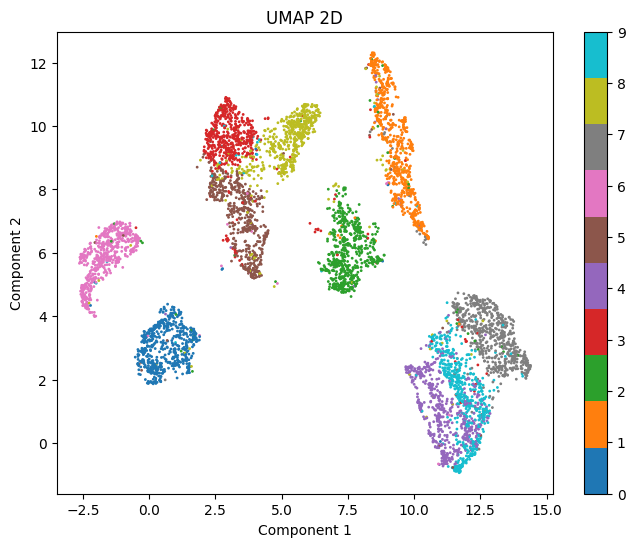

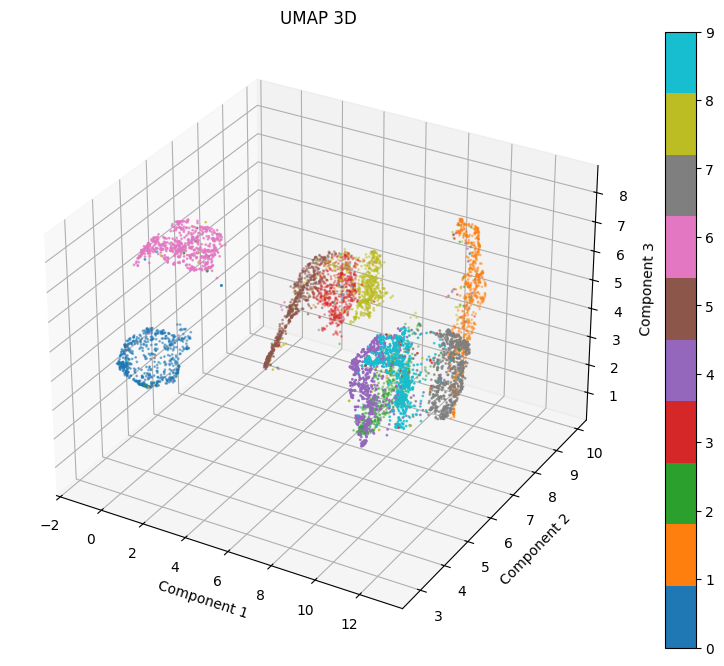

In [39]:
def plot_embedding_2d(data, y, title):
    # `data` is a 2D array of shape (n_samples, n_reduced_dimensions)
    # `y` is a 1D tensor of shape (n_samples), representing the labels
    y = y.numpy() # convert to numpy array to make matplotlib happy

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        # Value of data in the first dimension
        data[:, 0],
        # Value of data in the second dimension
        data[:, 1],
        # Color of each point, representing the label
        c=y.astype(int),
        # Use a categorical color map with 10 distinct colors
        cmap="tab10",
        # size of each point
        s=1,
    )
    # Add a color bar to the right of the plot
    plt.colorbar(scatter)

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    plt.show()

def plot_embedding_3d(data, y, title):
    # `data` is a 2D array of shape (n_samples, n_reduced_dimensions)
    # `y` is a 1D tensor of shape (n_samples), representing the labels
    y = y.numpy()  # convert to numpy array to make matplotlib happy

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        # Value of data in the first dimension
        data[:, 0],
        # Value of data in the second dimension
        data[:, 1],
        # Value of data in the third dimension
        data[:, 2],
        # Color of each point, representing the label
        c=y.astype(int),
        # Use a categorical color map with 10 distinct colors
        cmap="tab10",
        # size of each point
        s=1,
    )
    # Add a color bar to the right of the plot
    fig.colorbar(scatter)

    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")

    plt.show()

# Plot the UMAP projection
plot_embedding_2d(d2_test_sampled_umap, y_test, title="UMAP 2D")

plot_embedding_3d(d3_test_sampled_umap, y_test, title="UMAP 3D")

### Create a decoder network

It looks like UMAP *does* in fact separate this data quite nicely, so let's try constructing a decoder network and training it to get our original images back!

In [162]:
# First let's get UMAP encodings of all our datasets.
# Let's use 3 components to not make life toooo hard for our little network.
# Yes we already did this for our test data, but let's do it again to keep
# things readable from later cells.

def normalize_data(data):
    normalize = transforms.Normalize((0.5,), (0.5,))
    return normalize(torch.tensor(data).view(data.shape[0], 3, 1, 1)).view(-1, 3)

umapper = umap.UMAP(n_components=3)
x_train_umapped = normalize_data(umapper.fit_transform(x_train))
x_test_umapped  = normalize_data(umapper.transform(x_test))
x_val_umapped   = normalize_data(umapper.transform(x_val))

# Now let's shove them in data loaders for easier syntax in our training loop
def make_data_loader(x, y, batch_size=32):
    dataset = torch.utils.data.TensorDataset(x, y)
    return torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Note that our 'labels' are our original images, NOT the actual y labels (categories)
train_loader = make_data_loader(x_train_umapped, x_train)
test_loader = make_data_loader(x_test_umapped, x_test)
val_loader = make_data_loader(x_val_umapped, x_val)

In [136]:
# 6-Linear-Tanh Autodecoder
class Autodecoder_FC(nn.Module):
    def __init__(self, n_inputs=3):
        super(Autodecoder_FC, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(n_inputs, 8),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(8, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(16, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [148]:
# Configuration:
num_epochs = 100
learning_rate = 0.00001

## Train it!

Epoch [1/100], Training Loss: 0.2134
Validation Loss: 0.2153
Epoch [2/100], Training Loss: 0.1283
Validation Loss: 0.1333
Epoch [3/100], Training Loss: 0.1251
Validation Loss: 0.1140
Epoch [4/100], Training Loss: 0.1020
Validation Loss: 0.1062
Epoch [5/100], Training Loss: 0.1043
Validation Loss: 0.1015
Epoch [6/100], Training Loss: 0.0967
Validation Loss: 0.0986
Epoch [7/100], Training Loss: 0.0996
Validation Loss: 0.0962
Epoch [8/100], Training Loss: 0.0842
Validation Loss: 0.0948
Epoch [9/100], Training Loss: 0.0922
Validation Loss: 0.0932
Epoch [10/100], Training Loss: 0.0952
Validation Loss: 0.0929
Epoch [11/100], Training Loss: 0.0916
Validation Loss: 0.0914
Epoch [12/100], Training Loss: 0.0909
Validation Loss: 0.0912
Epoch [13/100], Training Loss: 0.0802
Validation Loss: 0.0905
Epoch [14/100], Training Loss: 0.0976
Validation Loss: 0.0904
Epoch [15/100], Training Loss: 0.0813
Validation Loss: 0.0897
Epoch [16/100], Training Loss: 0.0881
Validation Loss: 0.0887
Epoch [17/100], T

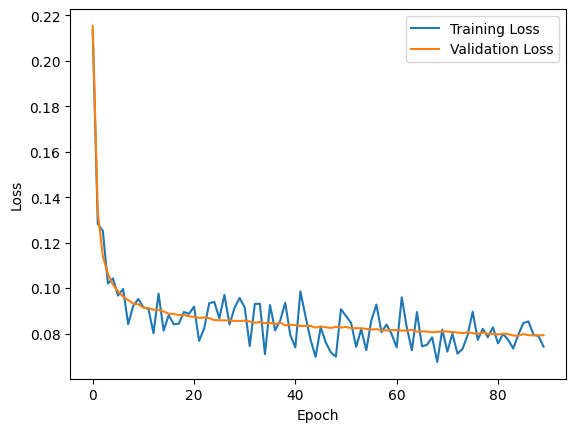

In [149]:
def train_model(model):
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    epoch_losses, validation_losses = [], []
    best_val_loss = float('inf')
    trigger_times = 0
    patience = 5

    for epoch in range(num_epochs):
        model.train()
        for umapped_img, original_img in train_loader:
            umapped_img, original_img = umapped_img.to(device), original_img.to(device)
            # Forward pass
            output_img = model(umapped_img)
            loss = criterion(output_img, original_img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}")

        # Calculate validation loss
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for umapped_img, original_img in val_loader:
                umapped_img, original_img = umapped_img.to(device), original_img.to(device)
                output_img = model(umapped_img)
                loss = criterion(output_img, original_img)
                validation_loss += loss.item()

        validation_loss /= len(val_loader)
        validation_losses.append(validation_loss)
        print(f"Validation Loss: {validation_loss:.4f}")

        # Early stopping logic
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping!")
                break

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

model = Autodecoder_FC().to(device)
train_model(model)

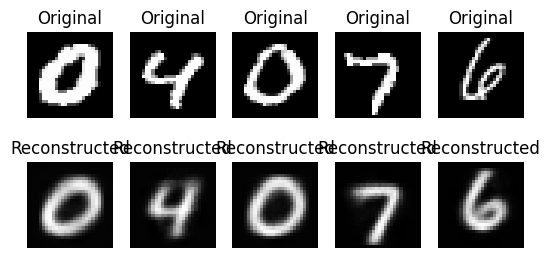

In [160]:
# Print a few examples
model.eval()
with torch.no_grad():
    # Visualize the first 5 images
    for umapped_imgs, original_imgs in test_loader:
        output_imgs = model(umapped_imgs.to(device))
        for i in range(5):
            plt.subplot(3, 5, i + 1)
            plt.imshow(original_imgs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Original")
            plt.axis("off")

            plt.subplot(3, 5, i + 6)
            plt.imshow(output_imgs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Reconstructed")
            plt.axis("off")
        plt.show()
        break
